# Analyse Interpolated PSF

PSF at Auxtel

Analyse the Interpolate the PSF within the simulated ray grid

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : June 4rd 2020
- update : June 5th 2020


In [1573]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse

import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import cm

In [1574]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [1575]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [1576]:
from scipy import interpolate
from scipy.optimize import curve_fit

In [1577]:
from sklearn.neighbors import NearestNeighbors

In [1578]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [1579]:
from datetime import datetime,date

In [1580]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

## Constants for conversions

In [1581]:
m_to_mm=1000.
mm_to_m=1e-3
mm_to_micr=1e3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
mm_to_nm=1e6
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm

In [1582]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [1583]:
deg_to_rad=np.pi/180.

In [1584]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [1585]:
Tel_Focal_Length=20.6 # m : Focal length of the telescope
Tel_Diameter=1.2 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
pltscale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

In [1586]:
print("plate_scale={:2.2f} arcsec per mm ".format(pltscale))

plate_scale=10.01 arcsec per mm 


In [1587]:
print("1 arsec = {:2.2f} microns".format(1/pltscale*mm_to_micr))

1 arsec = 99.87 microns


In [1588]:
1/pltscale*mm_to_micr/2.36*3

126.95532774812064

#### filter

In [1589]:
Filt_D=0.2 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [1590]:
Det_xpic=10.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=4096 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file

In [1591]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [1592]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [1593]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [1594]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [1595]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [1596]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [1597]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [1598]:
order="OP1"
order_str="+1"

# Read input files

## resampled beam files

In [1599]:
rayfile_R150="R150_RESAMPLEBEAM_Beam4_Rayfile_484_allwl_m00_m00_out.csv"
rayfile_HOE="HOE_RESAMPLEBEAM_Beam4_Rayfile_484_allwl_m00_m00_out.csv"

## reference file

In [1600]:
refrayfile_HOE="HOE_"+Beam4_Rayfile+"_RAY_OUT.xlsx"
refrayfile_R150="R150_"+Beam4_Rayfile+"_RAY_OUT.xlsx"

# Choose disperser

In [1601]:
FLAG_R150 = True
FLAG_HOE = False

In [1602]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [1603]:
if FLAG_R150:
    input_data_file=rayfile_R150
    input_data_reffile=refrayfile_R150
    disperser_name="Ronchi 150"
    disperser_tag="R150"
       
else:
    input_data_file=rayfile_HOE
    input_data_reffile=refrayfile_HOE
    disperser_name="Hologram"
    disperser_tag="HOE" 

# Read Files

In [1604]:
df=pd.read_csv(input_data_file)

In [1605]:
input_hoe = pd.ExcelFile(refrayfile_HOE)
df_hoe = input_hoe.parse(index_row=0,header=1)
#df_hoe=df_hoe.iloc[0:NBTOT]
df_hoe=df_hoe.drop(0)
# rename columns otherwise they are not recognize and swap X,Y
df_hoe.columns = ["X0","Y0","Z0","U0","V0","W0","wave","col","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xgoal","Ygoal","Xfinal","Yfinal","Zfinal","Notes","Unnamed"]

In [1606]:
input_R150 = pd.ExcelFile(refrayfile_R150)
df_R150 = input_R150.parse(index_row=0,header=1)
df_R150=df_R150.drop(0)
df_R150 = df_R150.reset_index()

In [1607]:
if FLAG_R150:
    df_ref=df_R150
else:
    df_ref=df_hoe

# Show beam at beginning of tracking

Text(0.5, 1.0, 'Simulated beam at start plane')

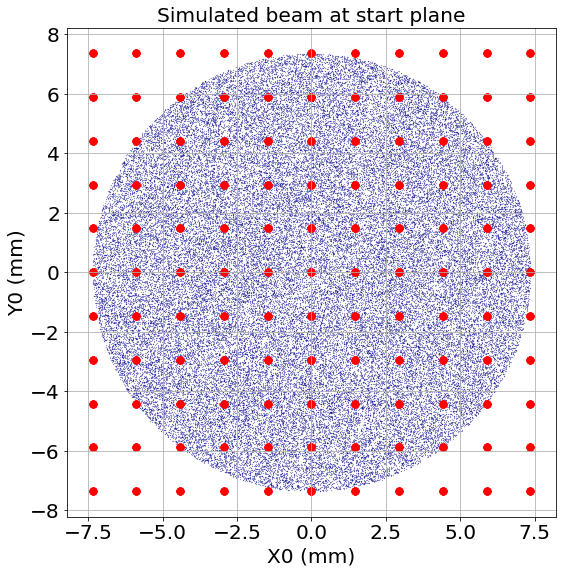

In [1608]:
f, ax1 = plt.subplots(figsize=(9,9))
df.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker=".",s=0.1,ax=ax1)
df_ref.plot.scatter(x="X0", y="Y0",c="red",marker="o",ax=ax1,s=50)
ax1.set(xlabel='X0 (mm)', ylabel='Y0 (mm)')
ax1.set_aspect("equal")
ax1.grid()
ax1.set_title("Simulated beam at start plane")

## Wavelength

In [1609]:
WLSIM = np.array([0.0004,0.0006,0.0008,0.001])

In [1610]:
idx_WLSEL=1
wlsim=WLSIM[idx_WLSEL]
wllabel="$\lambda = {:3.0f}$ nm".format(wlsim*mm_to_nm)

### Resampled beam

In [1611]:
if idx_WLSEL==0:
    Xccd=df["Xccd_400"].values
    Yccd=df["Yccd_400"].values
elif idx_WLSEL==1:
    Xccd=df["Xccd_600"].values
    Yccd=df["Yccd_600"].values
elif idx_WLSEL==2:
    Xccd=df["Xccd_800"].values
    Yccd=df["Yccd_800"].values
elif idx_WLSEL==3:  
    Xccd=df["Xccd_1000"].values
    Yccd=df["Yccd_1000"].values

### Reference beam

In [1612]:
df_ref=df_ref.loc[df_ref.wave==wlsim]

In [1613]:
Xccdref=df_ref["X3"].values
Yccdref=df_ref["Y3"].values

### Central beam

In [1614]:
central_beam=df_ref[(df_ref["X0"] == 0) & (df_ref["Y0"] == 0)]

In [1615]:
X3C=central_beam["X3"].values[0]
Y3C=central_beam["Y3"].values[0]

# PSF 2D

<Figure size 720x576 with 0 Axes>

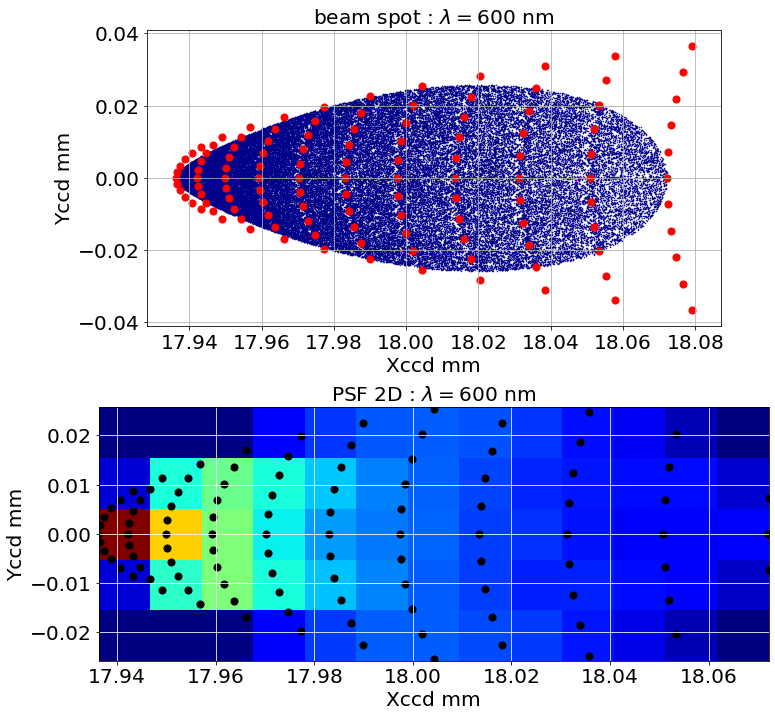

In [1616]:
plt.figure(figsize=(10,8))
f, (ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
NBINX=(Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm)
NBINY=(Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm) 

NBINX=max(NBINX,1)
NBINY=max(NBINY,1)


ax1.scatter(Xccd,Yccd,marker="." ,color="DarkBlue",s=1)
ax1.scatter(Xccdref,Yccdref,marker="o" ,color="Red",s=50)

ax1.grid()
ax1.set_aspect("equal")
ax1.set_xlabel("Xccd mm")
ax1.set_ylabel("Yccd mm")
title1="beam spot : "+ wllabel
ax1.set_title(title1)

ax2.hist2d(Xccd,Yccd,bins=(NBINX,NBINY),cmap=cm.get_cmap('jet'))
ax2.scatter(Xccdref,Yccdref,marker="o" ,color="k",s=50)
ax2.set_aspect("equal")
ax2.set_xlabel("Xccd mm")
ax2.set_ylabel("Yccd mm")
title2="PSF 2D : "+ wllabel
ax2.set_title(title2)
ax2.grid(b=True,color="white")

figname="PSFSIM_2D_"+disperser_tag+"_WL"+str(idx_WLSEL)+".pdf"
plt.savefig(figname)

# FWHM

In [1617]:
def ComputeFWHM(values,nbins=50,thetitle="fwhm",thexlabel="X (mm)",flagplot=False):
    """
    ComputeFWHM(values,nbins,flagplot)
    
    input arg :
       values : list of values
       nbins. : number of bins in the histogram
       flagplot : flag to plot the distribution
    """
    
    counts, bins =np.histogram(values,bins=nbins)
    
    # compute bin width
    binwidths=(np.roll(bins,-1)-bins)[:-1]
    binwidth=np.mean(binwidths)
    
    # find max
    idx_max=np.where(counts==counts.max())[0][0]
    count_max=counts[idx_max]
    counts_halfmax=count_max/2.
    
    # bins above half max
    topmost=np.where(counts>=counts_halfmax)[0]
    idx_min_fwhm=topmost[0]
    idx_max_fwhm=topmost[-1]
    
    # lower upper part
    min_fwhm=bins[idx_min_fwhm]+binwidth/2.
    max_fwhm=bins[idx_max_fwhm]+binwidth/2.
    
    #fwhm
    fwhm=max_fwhm-min_fwhm
    
    
    if flagplot:
        f, ax = plt.subplots(figsize=(10,5))
        
        ax.hist(bins[:-1]+binwidth/2., bins+binwidth/2., weights=counts,facecolor="red",density=False)
        ax.axhline(y=counts_halfmax)
        ax.axvline(x=min_fwhm,color="k")
        ax.axvline(x=max_fwhm,color="k")
        
        ax.grid()
        thetitle=thetitle+" = {:3.0f} $\mu m$".format(fwhm*1000)
        ax.set_title(thetitle)
        ax.set_xlabel(thexlabel)
        
    return fwhm
            

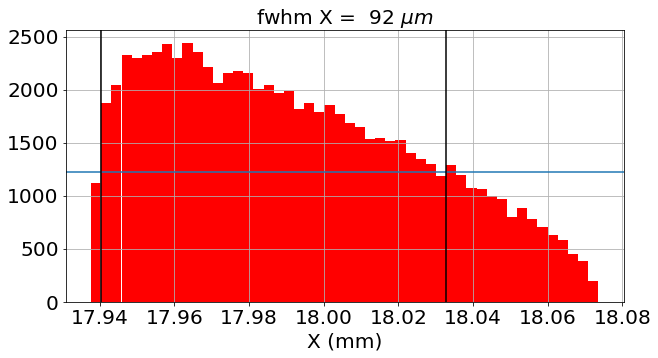

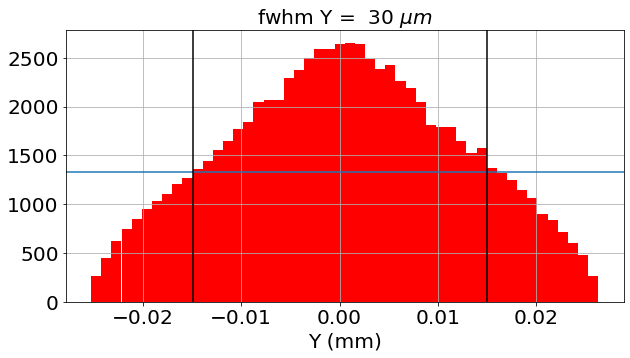

In [1618]:
fwhmX=ComputeFWHM(Xccd,50,thetitle="fwhm X",thexlabel="X (mm)",flagplot=True)
fwhmY=ComputeFWHM(Yccd,50,thetitle="fwhm Y",thexlabel="Y (mm)",flagplot=True)

### histogram in CCD pixels

In [1619]:
NBINSX=int((Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm))
NBINSY=int((Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm)) 


NBINSX=max(NBINSX,1)
NBINSY=max(NBINSY,1)

# compute the histogram
h1=np.histogram(Xccd,bins=NBINSX)
h2=np.histogram(Yccd,bins=NBINSY)

counts1, bins1 = h1
counts2, bins2 = h2


# compute bin width
# compute bin width
binwidths1=(np.roll(bins1,-1)-bins1)[:-1]
binwidth1=np.mean(binwidths1)

binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
binwidth2=np.mean(binwidths2)

# What to fit

theX1=(bins1+binwidth1/2)[:-1]
theY1=counts1

theX2=(bins2+binwidth2/2)[:-1]
theY2=counts2

<Figure size 864x720 with 0 Axes>

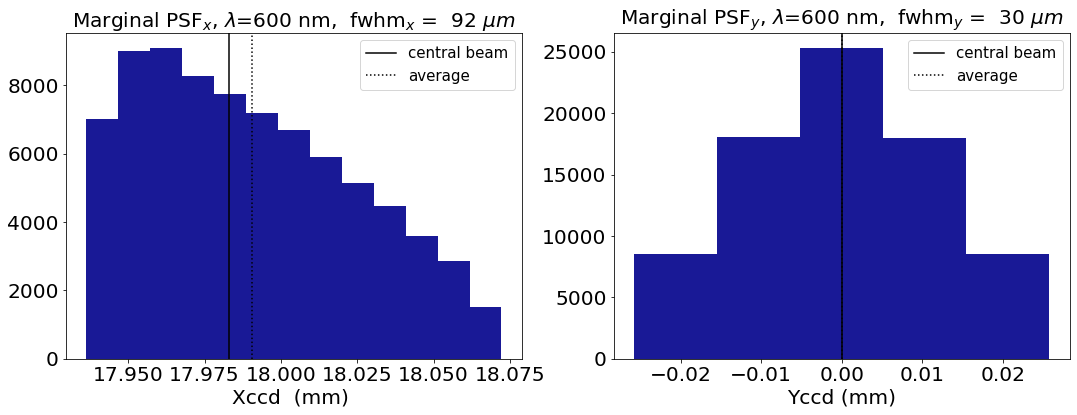

In [1620]:
plt.figure(figsize=(12,10))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,6))


# in X
#ax1.hist(Xccd,bins=NBINSX,facecolor="blue")
ax1.hist(bins1[:-1], bins1, weights=counts1,facecolor="DarkBlue",density=False,alpha=0.9)
ax1.set_xlabel("Xccd  (mm) ")
title1= "Marginal PSF$_x$, $\lambda$={:3.0f} nm,  fwhm$_x$ = {:3.0f} $\mu m$".format(wlsim*mm_to_nm,fwhmX*1000)
ax1.set_title(title1)
ax1.axvline(x=X3C,color="k",label="central beam")
ax1.axvline(x=Xccd.mean(),linestyle=":",color="k",label="average")
ax1.legend(fontsize=15)

# in Y
#ax2.hist(Yccd,bins=NBINSY,facecolor="blue")
ax2.hist(bins2[:-1], bins2, weights=counts2,facecolor="DarkBlue",density=False,alpha=0.9)
title2= "Marginal PSF$_y$, $\lambda$={:3.0f} nm,  fwhm$_y$ = {:3.0f} $\mu m$".format(wlsim*mm_to_nm,fwhmY*1000)
ax2.set_title(title2)
ax2.set_xlabel("Yccd (mm)")
ax2.axvline(x=Y3C,color="k",label="central beam")
ax2.axvline(x=Yccd.mean(),linestyle=":",color="k",label="average")
ax2.legend(fontsize=15)


figname="PSFSIM_1D_"+disperser_tag+"_WL"+str(idx_WLSEL)+".pdf"
plt.savefig(figname)

# Fit

## prepare the data to fit

In [1621]:
Xpos=Xccd
Ypos=Yccd

NBINS=50

RX=Xpos.max()-Xpos.mean()
RY=Ypos.max()-Ypos.mean()

# compute the histogram
h1=np.histogram(Xpos,bins=NBINS)
h2=np.histogram(Ypos,bins=NBINS)
counts1, bins1 = h1
counts2, bins2 = h2

# compute bin width
binwidths1=(np.roll(bins1,-1)-bins1)[:-1]
binwidth1=np.mean(binwidths1)

binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
binwidth2=np.mean(binwidths2)

# What to fit
theX1=(bins1+binwidth1/2)[:-1]
theY1=counts1

theX2=(bins2+binwidth2/2)[:-1]
theY2=counts2

## Astropy fit

### Astropy Fitter

In [1622]:
# fitter 
#fitter = fitting.LinearLSQFitter() # linear in fit parameter
fitter = fitting.LevMarLSQFitter() 

### Astropy model (Not working)

In [1623]:
@custom_model
def disk1D(x,a=10.,b=10.,c=0.):
    """
    R=b
    c=x0
    f(x)=a/pi/R*sqrt(1-x**2/R**2)
    """
    R=b
    x0=c
    
    if R<0:
        return 0
    
    D=(x-x0)**2/R**2
    
    funct=np.where(D<1.,a/np.pi*np.sqrt(1.-D),0)
    
    return funct

## Function for fitting

In [1624]:
def disk1D_2(x,a=10.,b=10.,c=0.):
    """
    R=b
    c=x0
    f(x)=a/pi/R*sqrt(1-x**2/R**2)
    """
    R=b
    x0=c
    
    if R<0:
        return 0
    
    D=(x-x0)**2/R**2
    
    
    funct=np.where(D<1.,a/np.pi*np.sqrt(1.-D),0)
    
    return funct

## Init parameters

In [1625]:
Ainit1=len(Xpos)/NBINS*4
Binit1=RX
Cinit1=Xpos.mean()
#Xfit=np.linspace(C-RX,C+RX,50)
#Yfit=disk1D_2(Xfit,a=A, b=RX, c=C)

## Fit with astropy

In [1626]:
model_disk1d = disk1D(a=Ainit1, b=Binit1, c=Cinit1)

In [1627]:
best_fit_disk=fitter(model_disk1d, theX1,theY1,weights=1)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [1628]:
print(best_fit_disk)

Model: disk1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                  b                  c         
    ----------------- ------------------- ------------------
    6356.672007581746 0.09910061679096605 17.962488785532933


In [1629]:
Afit1=best_fit_disk.a.value
Bfit1=best_fit_disk.b.value
Cfit1=best_fit_disk.c.value

In [1630]:
Afit1

6356.672007581746

In [1631]:
Bfit1

0.09910061679096605

In [1632]:
Cfit1

17.962488785532933

## Fit with scipy

In [1633]:
popt, pcov = curve_fit(disk1D_2, theX1, theY1,p0=(Ainit1,Binit1,Cinit1))

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [1634]:
Afit1=popt[0]
Bfit1=popt[1]
Cfit1=popt[2]

## plot fit result

In [1635]:
Xfit1=np.linspace(Cinit1-RX*1.2,Cinit1+RX*1.2,50)
Yfit1=disk1D_2(Xfit1,a=Afit1, b=Bfit1, c=Cfit1)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


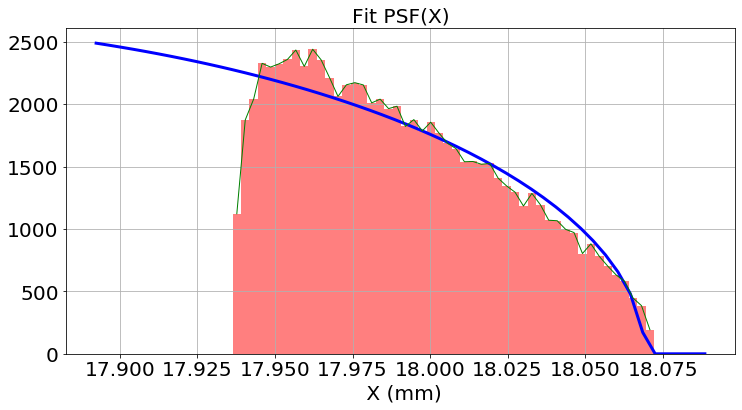

In [1636]:
f, ax = plt.subplots(figsize=(12,6))
ax.hist(bins1[:-1], bins1, weights=counts1,facecolor="red",alpha=0.5,density=False)
ax.plot(Xfit1,Yfit1,"b",lw=3)
ax.plot(theX1,theY1,"g-",lw=1)
ax.set_xlabel(" X (mm)")
ax.set_title("Fit PSF(X)")
ax.grid()

In [1637]:
Ainit2=len(Ypos)/NBINS*4
Binit2=RY
Cinit2=Ypos.mean()

## Fit with astropy

In [1638]:
model_disk1d = disk1D(a=Ainit2, b=Binit2, c=Cinit2)

In [1639]:
best_fit_disk=fitter(model_disk1d, theX2,theY2,weights=1)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [1640]:
print(best_fit_disk)

Model: disk1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                  b                     c           
    ----------------- -------------------- ----------------------
    6711.422471453631 0.024356449003231445 1.2324839007537557e-05


In [1641]:
Afit2=best_fit_disk.a.value
Bfit2=best_fit_disk.b.value
Cfit2=best_fit_disk.c.value

## Fit with scipy

In [1642]:
popt, pcov = curve_fit(disk1D_2, theX2, theY2,p0=(Ainit2,Binit2,Cinit2))

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [1643]:
Afit2=popt[0]
Bfit2=popt[1]
Cfit2=popt[2]

## Plot fit result

In [1644]:
Xfit2=np.linspace(Cinit2-RY*1.2,Cinit2+RY*1.2,50)
Yfit2=disk1D_2(Xfit2,a=Afit2, b=Bfit2, c=Cfit2)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


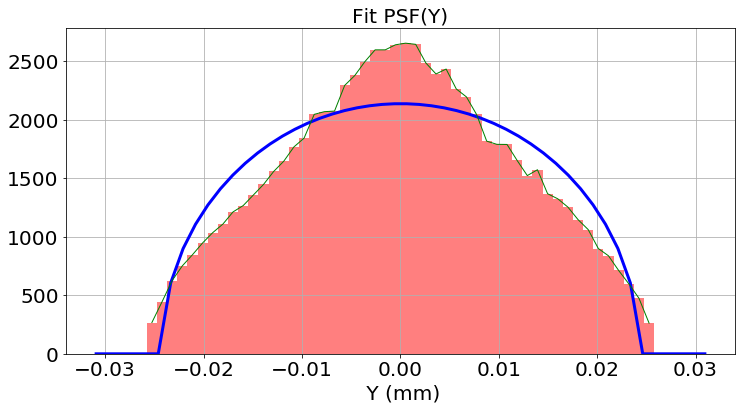

In [1645]:
f, ax = plt.subplots(figsize=(12,6))
ax.hist(bins2[:-1], bins2, weights=counts2,facecolor="red",alpha=0.5,density=False)
ax.plot(Xfit2,Yfit2,"b",lw=3)
ax.plot(theX2,theY2,"g-",lw=1)
ax.set_xlabel(" Y (mm)")
ax.set_title("Fit PSF(Y)")
ax.grid()